In [29]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [30]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels,in_channels,3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels,in_channels,3),
            nn.InstanceNorm2d(in_channels)
        )
    def forward(self, x):
        return x + self.block(x)

In [31]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet,self).__init__()

        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(in_channels,out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        channels = out_channels

        self.down = []

        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)

        # Upsampling  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = []
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)

        # Out layer  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x


In [32]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            # why normalize=False?
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128 
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32
            *self.block(256, 512), # 256*32*32 -> 512*16*16
            
            # Why padding first then convolution?
            nn.ZeroPad2d((1,0,1,0)), # padding left and top   512*16*16 -> 512*17*17
            nn.Conv2d(512, 1, 4, padding=1) # 512*17*17 -> 1*16*16
        )
        
        self.scale_factor = 16
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, x):
        return self.model(x)

In [33]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

In [34]:
G_AB = GeneratorResNet(3, num_residual_blocks=9)
D_B = Discriminator(3)

G_BA = GeneratorResNet(3, num_residual_blocks=9)
D_A = Discriminator(3)

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [36]:
count_parameters(D_B)

2764737

In [37]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')
if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    
    criterion_GAN = criterion_GAN.cuda()
    criterion_cycle = criterion_cycle.cuda()
    criterion_identity = criterion_identity.cuda()

cuda: True


In [38]:
import itertools
lr = 0.0005
b1 = 0.5
b2 = 0.996

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1, b2)
)

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1, b2)
)

In [46]:
n_epoches = 50
decay_epoch = 15

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

In [40]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, data_dir, mode='train', transforms=None):
        A_dir = os.path.join(data_dir, 'monet_jpg')
        B_dir = os.path.join(data_dir, 'photo_jpg')
        
        if mode == 'train':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[:250]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[:250]]
        elif mode == 'test':
            self.files_A = [os.path.join(A_dir, name) for name in sorted(os.listdir(A_dir))[250:]]
            self.files_B = [os.path.join(B_dir, name) for name in sorted(os.listdir(B_dir))[250:301]]
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.files_A)
    
    def __getitem__(self, index):
        file_A = self.files_A[index]
        file_B = self.files_B[index]
        
        img_A = Image.open(file_A)
        img_B = Image.open(file_B)
        
        if self.transforms is not None:
            img_A = self.transforms(img_A)
            img_B = self.transforms(img_B)
        
        return img_A, img_B

In [41]:
import torchvision.transforms as transforms

data_dir = '/kaggle/input/gan-getting-started'

transforms_ = transforms.Compose([
   # transforms.Resize(int(256*1.12), Image.BICUBIC),
    #transforms.RandomCrop(256, 256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 2

trainloader = DataLoader(
    ImageDataset(data_dir, mode='train', transforms=transforms_),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0
)

testloader = DataLoader(
    ImageDataset(data_dir, mode='test', transforms=transforms_),
    batch_size = batch_size,
    shuffle = False,
    num_workers = 0
)


In [42]:
from torchvision.utils import make_grid

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images(real_A, real_B, figside=1.5):
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'
    print(real_A.size())
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()

    print(real_A.size())
    
    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(real_B, nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(figside*nrows, figside*4))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()
    

torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])


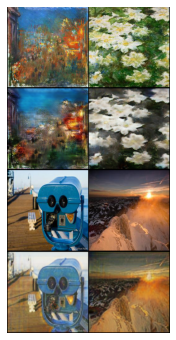

In [45]:
real_A, real_B = next(iter(testloader))
print(real_A.size())
sample_images(real_A, real_B)

In [44]:
G_AB, G_BA = torch.load("./weights/G_AB.pt"), torch.load("./weights/G_BA.pt")
D_A, D_B = torch.load("./weights/D_A.pt"), torch.load("./weights/D_B.pt")


torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])


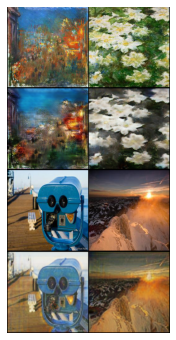

[Epoch 10/50]
[G loss: 2.701859951019287 | identity: 0.17380256950855255 GAN: 0.8278988599777222 cycle: 0.10049483180046082]
[D loss: 0.017196957021951675 | D_A: 0.006959013175219297 D_B: 0.027434900403022766]
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])


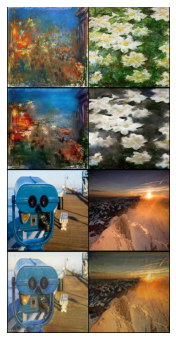

[Epoch 20/50]
[G loss: 2.851208209991455 | identity: 0.1466805338859558 GAN: 0.934066653251648 cycle: 0.11837387830018997]
[D loss: 0.014497529715299606 | D_A: 0.009831640869379044 D_B: 0.01916341856122017]
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])


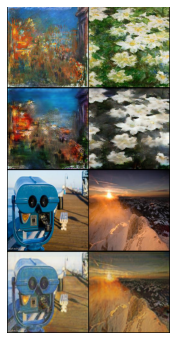

[Epoch 30/50]
[G loss: 2.764360189437866 | identity: 0.1442369520664215 GAN: 0.9613412022590637 cycle: 0.10818342864513397]
[D loss: 0.01877901330590248 | D_A: 0.007651947904378176 D_B: 0.029906077310442924]
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])


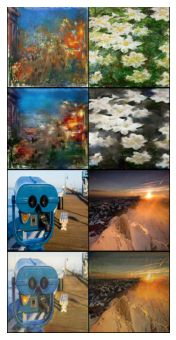

[Epoch 40/50]
[G loss: 2.930980920791626 | identity: 0.14486122131347656 GAN: 0.8646424412727356 cycle: 0.134203240275383]
[D loss: 0.024242538958787918 | D_A: 0.009159408509731293 D_B: 0.03932566940784454]
torch.Size([2, 3, 256, 256])
torch.Size([2, 3, 256, 256])


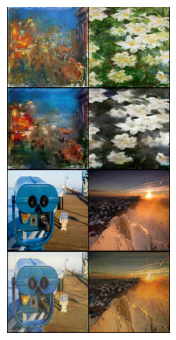

[Epoch 50/50]
[G loss: 3.1504666805267334 | identity: 0.17410822212696075 GAN: 0.8987058997154236 cycle: 0.13812196254730225]
[D loss: 0.026498859748244286 | D_A: 0.013490874320268631 D_B: 0.03950684517621994]


In [47]:
for epoch in range(n_epoches):
    for i, (real_A, real_B) in enumerate(trainloader):
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)
        
        # groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        """Train Generators"""
        # set to training mode in the begining, beacause sample_images will set it to eval mode
        G_AB.train()
        G_BA.train()
        
        optimizer_G.zero_grad()
        
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)
        
        # identity loss
        loss_id_A = criterion_identity(fake_B, real_A)
        loss_id_B = criterion_identity(fake_A, real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2
        
        # GAN loss, train G to make D think it's true
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) 
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        # cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        # G totol loss
        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        """Train Discriminator A"""
        optimizer_D_A.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        """Train Discriminator B"""
        optimizer_D_B.zero_grad()
        
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
    
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
    # test
    if (epoch+1) % 10 == 0:
        test_real_A, test_real_B = next(iter(testloader))
        sample_images(test_real_A, test_real_B)

        loss_D = (loss_D_A + loss_D_B) / 2
        print(f'[Epoch {epoch+1}/{n_epoches}]')
        print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]')    

In [48]:
PATH = './weights/'

In [49]:
torch.save(G_AB, PATH + 'G_AB.pt')
torch.save(D_B, PATH + 'D_B.pt')
torch.save(G_BA, PATH + 'G_BA.pt')
torch.save(D_A, PATH + 'D_A.pt')